In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import corner
import glob, dill, sys, os

import seaborn as sns
sns.set(style='ticks', font_scale=1.6, font='times')
from matplotlib import rc
rc('text', usetex=True)

In [160]:
keys = ['R_break', 'lnxsigma', 'logrsigma', 'p_break', 'power_long', 'power_short']#, 'xsigma', 'lnp_break']
labels = ["$R_\mathrm{break}$ (ppm)", "$\ln \sigma_{\ln P}$ (days)", "$\ln \sigma_{\ln R}$ (ppm)", "$P_\mathrm{break}$ (days)", 
          r"$\beta_\mathrm{unsat}$", r"$\beta_\mathrm{sat}$"] 
logs = [True, False, False, True*0, False, False]

In [167]:
def summary_plots(resdir, dt):
    sall = None
    figdir = resdir[:-1]+"_plots/"
    if not os.path.exists(figdir):
        os.system("mkdir %s"%figdir)
    files = glob.glob(resdir+"*.pkl")
    files.sort()
    d = pd.DataFrame({})
    for i,file in enumerate(files):
        _f = file.split("/")[1]
        tl, tu = float(_f[4:8]), float(_f[9:13])
        if tu - tl > 1000:
            sall = dill.load(open(file, 'rb')).get_samples()
            continue
        s = dill.load(open(file, 'rb')).get_samples()
        dic = {"tl": tl, "tu": tu, "t": 0.5*(tl+tu)}
        for k in keys:
            dic[k+"_mean"] = np.mean(s[k])
            dic[k+"_median"] = np.median(s[k])
            dic[k+"5"], dic[k+"95"] = np.percentile(s[k], [5, 95])
            dic[k+"_upp"] = dic[k+"95"] - dic[k+"_mean"]
            dic[k+"_low"] = -dic[k+"5"] + dic[k+"_mean"]
        d = d.append([dic])

    for i in range(len(keys)):
        key = keys[i]
        plt.figure(figsize=(12,7))
        plt.xlim(4000+100, 6500-200)
        plt.xlabel("LAMOST $T_\mathrm{eff}$ (K)")
        if logs[i]:
            plt.yscale("log")
        if key=='p_break' and 'ro' in resdir:
            _label = "$\mathrm{Ro}_\mathrm{break}$"
            plt.ylabel(_label)
            plt.yscale("linear")
        elif key=='lnxsigma' and 'ro' in resdir:
            _label = "$\ln \sigma_{\ln \mathrm{Ro}}$"
            plt.ylabel(_label)
        else:
            _label = labels[i]
            plt.ylabel(labels[i])
        idx = (4200 <= d.t) & (d.t <= 6200)
        plt.errorbar(d.t[idx], d[key+"_mean"][idx], yerr=[d[key+"_low"][idx], d[key+"_upp"][idx]], 
                     fmt='o', lw=1, xerr=0.5*dt, color='gray')
        if sall is not None:
            allm = np.mean(sall[key])
            all5, all95 = np.percentile(sall[key], [5,95])
            plt.axhline(y=allm, color='C1', ls='dashed', lw=1, 
                        label=_label+"$=%.2f^{+%.2f}_{-%.2f}$\n(mean \& 90%s from the entire sample)"%(allm, all95-allm, allm-all5, "\%"))
            plt.fill_between(np.linspace(4100, 6300, 100), all5, all95, color='C1', alpha=0.2)
            plt.legend(loc='best')
        plt.savefig(figdir+"%s_teff.png"%key, dpi=200, bbox_inches="tight")

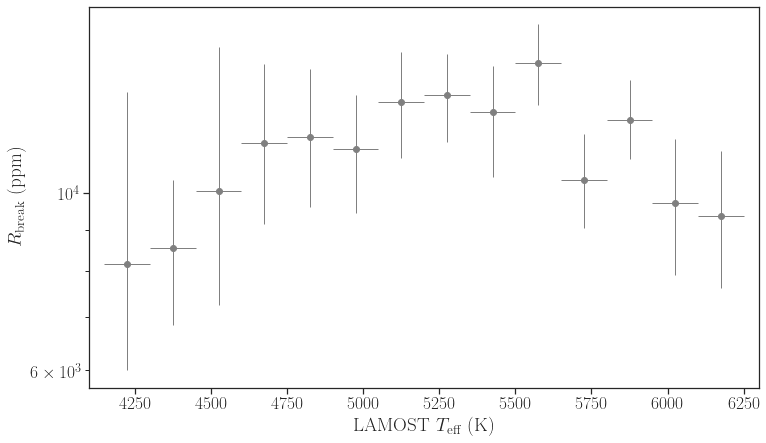

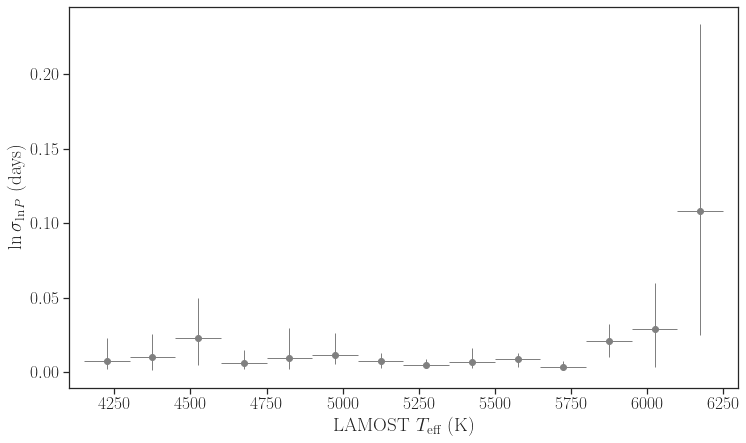

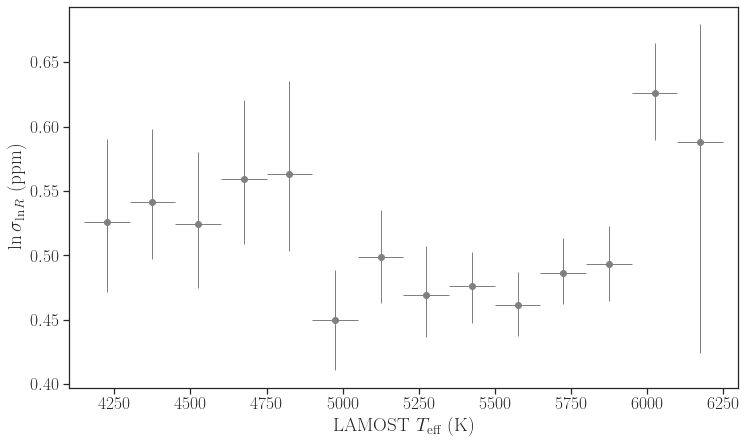

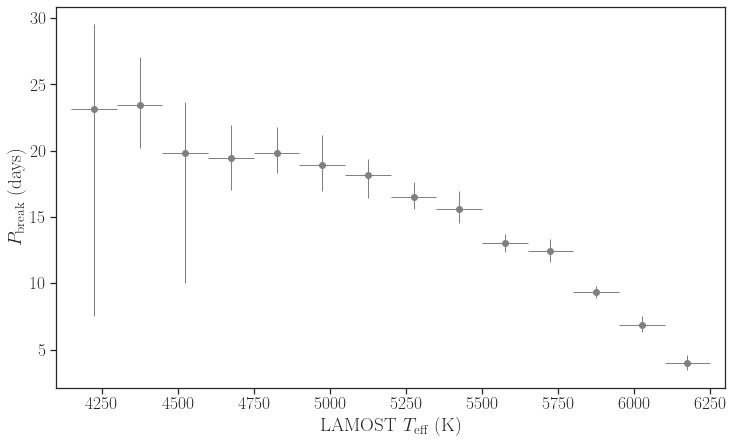

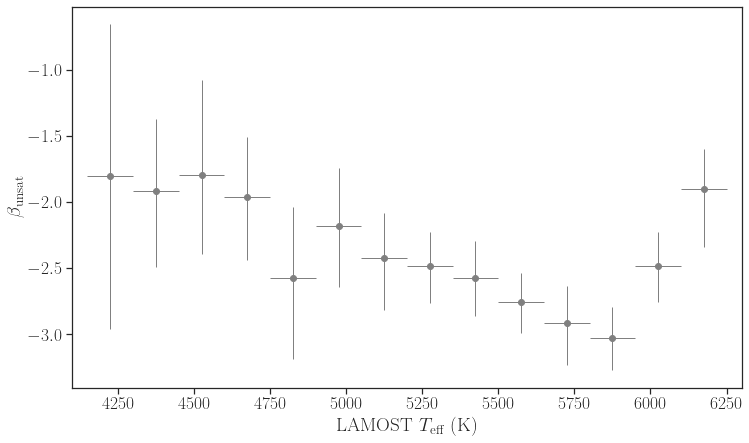

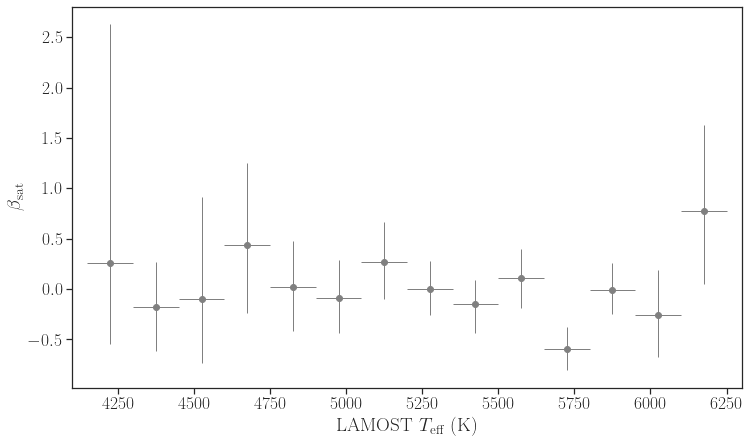

In [168]:
dt = 150
resdir = 'plfit_results_t%d_pct/'%dt
summary_plots(resdir, dt)

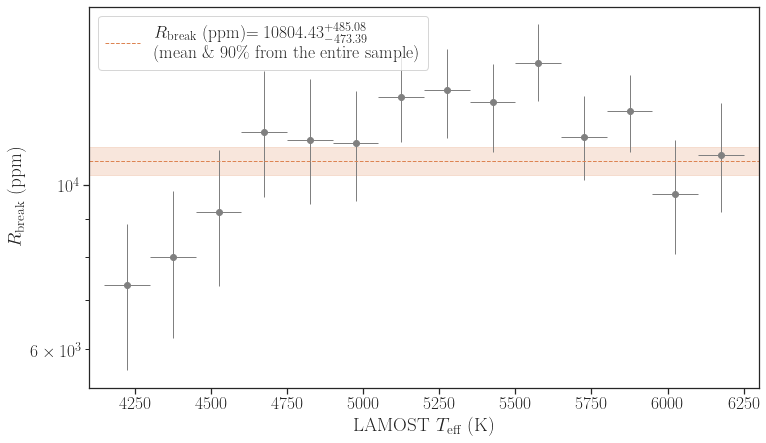

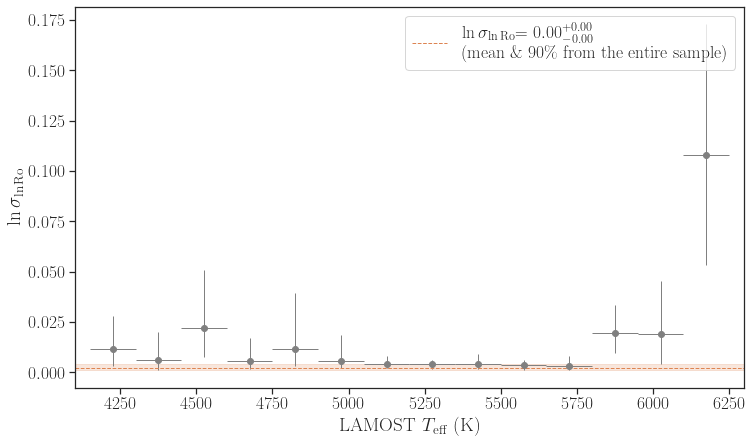

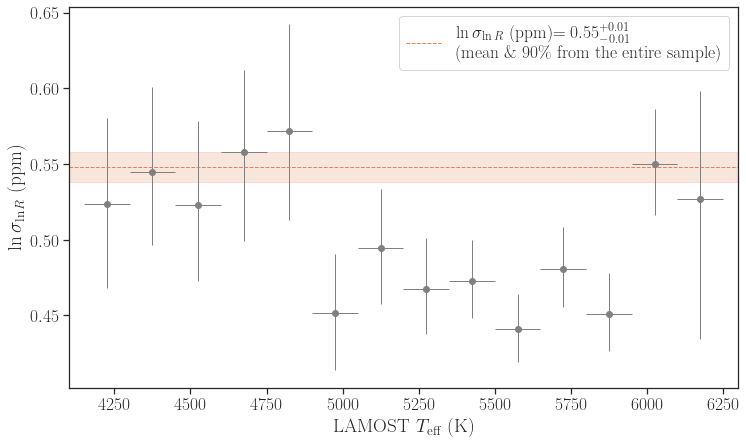

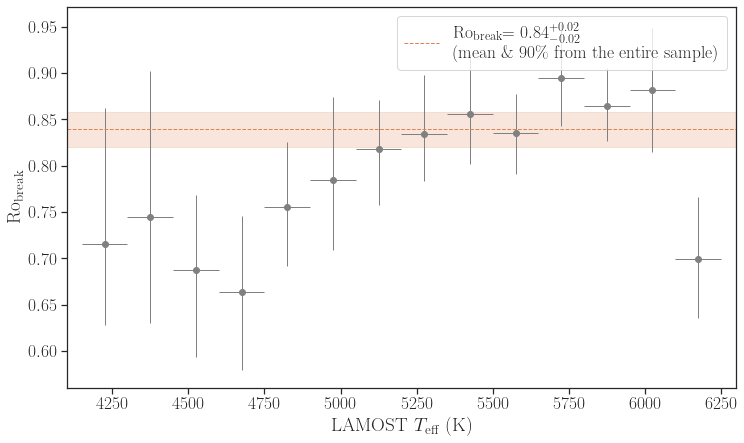

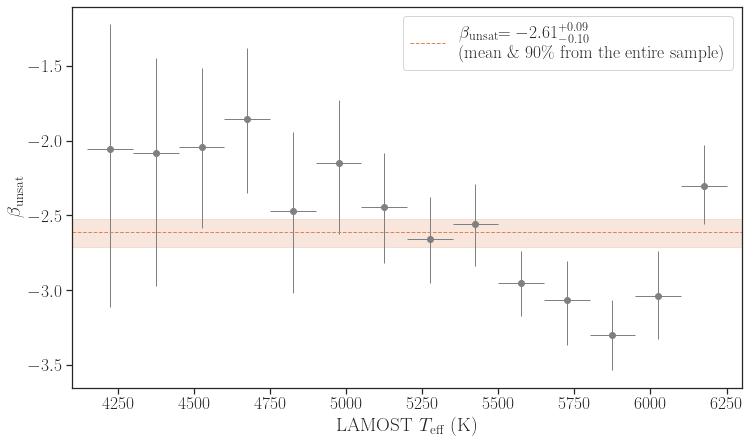

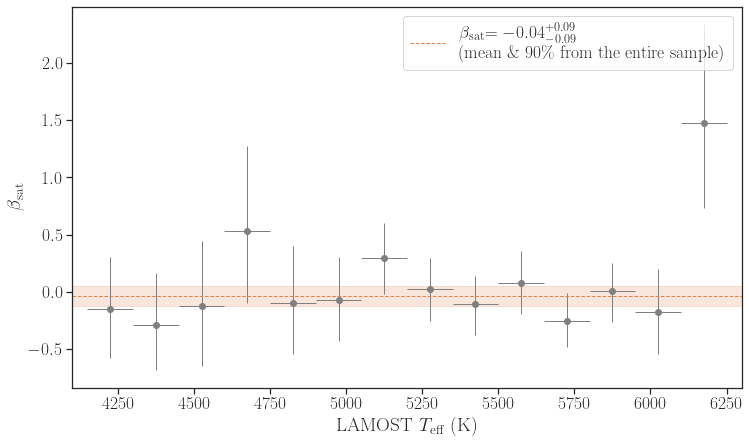

In [169]:
dt = 150
resdir = 'plfitro_results_t%d_pct/'%dt
summary_plots(resdir, dt)

In [116]:
postall = "plfitro_results_t150_pct/teff4000-6250_mcmc.pkl"
#postall = "plfitro_results_t200_pct/teff4000-6200_mcmc.pkl"

In [117]:
s = dill.load(open(postall, 'rb')).get_samples()

In [118]:
keys = ['R_break', 'p_break', 'power_long', 'power_short', 'lnxsigma', 'logrsigma']#, 'xsigma', 'lnp_break']
labels = ["$R_\mathrm{break}$ (ppm)", "$\mathrm{Ro}_\mathrm{break}$", 
          r"$\beta_\mathrm{unsat}$", r"$\beta_\mathrm{sat}$",
          "$\ln \sigma_{\ln\mathrm{Ro}}$", "$\ln \sigma_{\ln R}$ (ppm)"] 

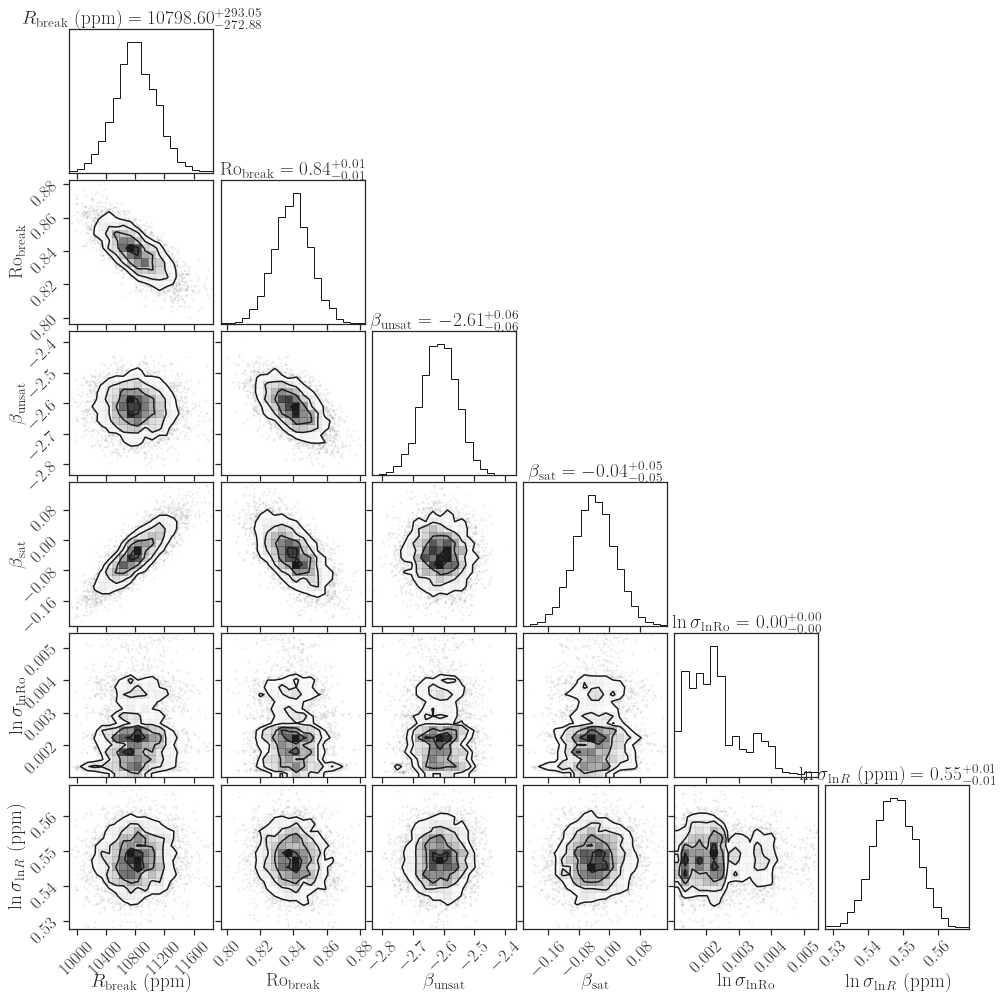

In [119]:
hyper = pd.DataFrame(data=dict(zip(keys, [s[k] for k in keys])))
fig = corner.corner(hyper, labels=labels, show_titles="%.2f")
plt.savefig(postall.split("/")[0]+"_plots/all_corner.png", dpi=200, bbox_inches="tight")

In [18]:
import numpyro
import numpyro.distributions as dist
import jax.numpy as jnp
import jax.random as random
from numpyro.infer import init_to_value

In [85]:
keys = ['power_long', 'power_short', "p_break", "lnRbreak"]
mulims = [[-5,-1], [-3,3], [0,2], [3,5],]
slims = [[0,3], [0,3], [0,1], [0,2]]

In [86]:
def model(samples, mulim, slim):
    mu = numpyro.sample("mu", dist.Uniform(mulim[0], mulim[1]))
    sigma = numpyro.sample("sigma", dist.Uniform(slim[0], slim[1]))
    norm = dist.Normal(loc=mu, scale=sigma)
    lnprob = numpyro.deterministic("lnprob", jnp.log(jnp.prod(jnp.mean(jnp.exp(norm.log_prob(samples)), axis=1))))
    numpyro.factor("lnlike", lnprob)

In [87]:
resdir = 'plfitro_results_t%d_pct/'%dt
figdir = resdir[:-1]+"_plots/"

In [89]:
resdir = 'plfit_results_t%d_pct/'%dt
figdir = resdir[:-1]+"_plots/"

sample: 100%|███████████| 2000/2000 [00:02<00:00, 779.11it/s, 7 steps of size 5.36e-01. acc. prob=0.96]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu     -2.09      0.25     -2.08     -2.49     -1.70    493.25      1.00
     sigma      0.96      0.21      0.93      0.63      1.28    539.74      1.00

Number of divergences: 0


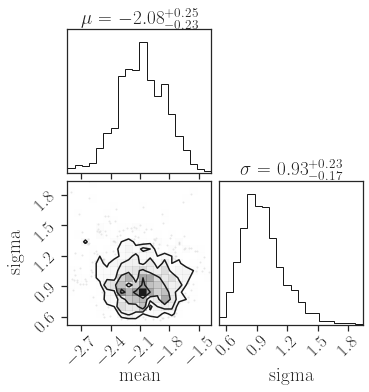

In [92]:
for i in range(len(keys)):
    key, mulim, slim = keys[i], mulims[i], slims[i]
    
    if key=='p_break' and ('ro' not in resdir):
        continue
    
    samples = []
    files = glob.glob(resdir+"*.pkl")
    files.sort()
    for i,file in enumerate(files):
        _f = file.split("/")[1]
        tl, tu = float(_f[4:8]), float(_f[9:13])
        s = dill.load(open(file, 'rb')).get_samples()
        s['lnRbreak'] = jnp.log10(s['R_break'])
        samples.append(s[key])
    samples = np.array(samples)
    
    kernel = numpyro.infer.NUTS(model, target_accept_prob=0.9)
    nw, ns = 1000, 1000
    mcmc = numpyro.infer.MCMC(kernel, num_warmup=nw, num_samples=ns)
    rng_key = random.PRNGKey(0)
    mcmc.run(rng_key, samples, mulim, slim)
    mcmc.print_summary()
    
    _s = mcmc.get_samples()
    fig = corner.corner(np.array([_s['mu'], _s['sigma']]).T, labels=['mean', 'sigma'], 
                        titles=['$\mu$', '$\sigma$'], show_titles=True)
    plt.savefig(figdir+"musigma_%s.png"%key, dpi=200, bbox_inches='tight')

sample: 100%|███████████| 2000/2000 [00:02<00:00, 759.28it/s, 7 steps of size 3.32e-01. acc. prob=0.98]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu     -2.30      0.26     -2.31     -2.69     -1.84    455.71      1.00
     sigma      0.93      0.20      0.90      0.63      1.23    281.20      1.00

Number of divergences: 0


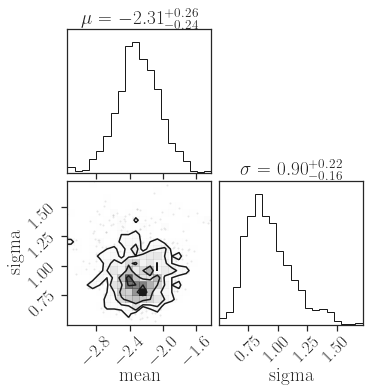

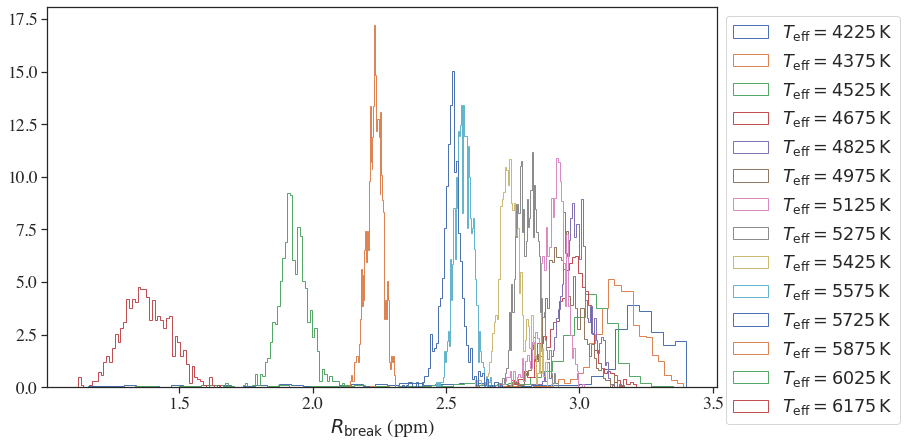

In [46]:
plt.figure(figsize=(12,7))
plt.xlabel("$R_\mathrm{break}$ (ppm)")
for i in range(1,len(dt)-1):
    s = np.array(results[i][key])
    if log:
        s = np.log(s)
    label = "$T_\mathrm{eff}=%d\,\mathrm{K}$"%dt['t'][i]
    plt.hist(s, bins=50, histtype='step', lw=1, density=True, label=label)
plt.legend(loc='best', bbox_to_anchor=(1,1));

In [ ]:
s.keys()

In [ ]:
logg_threshold = 4.
"""
def logg_teff_cut(teff):
    if teff>6200:
        return 4.1
    elif teff>5400:
        return 4.1 + 0.3*(6200.-teff)/800.
    else:
        return 4.4
logg_threshold = np.array([logg_teff_cut(_t0) for _t0 in d.teff])
resdir = 'plfit_results_t200g_p%d-%d/'%(pmin, pmax)
"""

In [ ]:
for i in range(len(tbins)-1):
    tl, tu = tbins[i], tbins[i+1]
    idx = (d.teff>tl) & (d.teff<tu) & (d.logg>logg_threshold)
    pobs = np.array(d[idx].Prot)
    print (tl, tu, np.percentile(pobs, [5, 10, 50, 90, 95]))

In [ ]:
plt.xlabel("LAMOST Teff")
plt.ylabel("count")
plt.hist(d.teff, bins=tbins);

In [ ]:
#pmin, pmax = 1., 100.
#pmin, pmax = 2., 50.
#pmin, pmax = 3., 30.

In [ ]:
#resdir = 'plfit_results_p2-50/'
#resdir = 'plfit_results_p3-30/'
#resdir = 'plfit_results_t200_p%d-%d/'%(pmin, pmax)


In [ ]:
resume = True*0

In [ ]:
for i in range(len(tbins)-1):
#for i in range(7,8):
    tl, tu = tbins[i], tbins[i+1]
    outname = resdir+"teff%d-%d"%(tl, tu)
    print (outname)    

    idx = (d.teff>tl) & (d.teff<tu) & (d.logg>logg_threshold)
    pmin, pmax = np.percentile(d[idx].Prot, [5, 95])
    print (pmin, pmax)
    #pmin, pmax = 1., 100.
    
    idxp = (pmin<d.Prot) & (d.Prot<pmax)
    pobs, robs = jnp.array(d[idx&idxp].Prot), jnp.array(d[idx&idxp].Rper)
    pobs_out, robs_out = d[idx&(~idxp)].Prot, d[idx&(~idxp)].Rper
    
    filename = outname + "_mcmc.pkl"
    if os.path.exists(filename) and resume:
        mcmc = dill.load(open(filename, 'rb'))    
    else:   
        init_strategy = init_to_value(values={"lnxmodel": jnp.log(pobs)})
        kernel = numpyro.infer.NUTS(model, target_accept_prob=0.9, init_strategy=init_strategy)
        nw, ns = 1000, 1000
        mcmc = numpyro.infer.MCMC(kernel, num_warmup=nw, num_samples=ns)
        rng_key = random.PRNGKey(0)
        mcmc.run(rng_key, pobs, robs, pmin, pmax, extra_fields=('potential_energy',))
        #mcmc.print_summary()
        with open(outname+"_mcmc.pkl", "wb") as f:
            dill.dump(mcmc, f)

    samples = mcmc.get_samples()

    pmod = jnp.mean(samples['xmodeldense'], axis=0)
    rmean = jnp.mean(samples['rmodeldense'], axis=0)
    r5, r95 = jnp.percentile(samples['rmodeldense'], q=jnp.array([5, 95]), axis=0)
    rsigmamean = jnp.mean(jnp.exp(samples['logrsigma']))
    pb, pbsd = jnp.mean(samples['p_break']), jnp.std(samples['p_break'])
    pb5, pb95 = jnp.percentile(samples['p_break'], q=jnp.array([5,95]))

    plt.figure(figsize=(12,6))
    plt.title("$T_\mathrm{eff}=%d\,\mathrm{K}$-$%d\,\mathrm{K}$"%(tl, tu))
    plt.ylim(1e1, 1e6)
    plt.xlim(1, 100)
    plt.yscale("log")
    plt.xscale("log")
    plt.ylabel(rlabel)
    plt.xlabel(protlabel)
    #idxd = (pobs>pmin) & (pobs<pmax)
    plt.plot(pobs, robs, '.', color='gray', mfc='none', mew=1, zorder=1000, label='data')
    plt.plot(pobs_out, robs_out, '.', color='gray', mfc='none', mew=1, zorder=1000, alpha=0.4)
    plt.plot(pmod, rmean, '-', color='C1', label='$R_\mathrm{per}$ model (mean \& 90\% interval)')
    #plt.axvline(x=pbreak, label='$P_\mathrm{break}=%.1f\pm%.1f\,\mathrm{days}$'%(pbreak, pbreak_sd), 
    #            color='C1', ls='dotted', lw=1)
    plt.axvline(x=pb, color='C1', ls='dotted', lw=1, label='$P_\mathrm{break}$ (mean \& 90\% interval)')
                #label='$P_\mathrm{break}=%.1f\pm%.1f\,\mathrm{days}$'%(pb, pbsd), )
    plt.fill_betweenx(np.logspace(1,6,100), x1=pb5, x2=pb95, color='C1', lw=0, alpha=0.1,)
                      #label='90\% interval for $P_\mathrm{break}$')
    #plt.axvline(x=tau_cz(0.5*(tl+tu)), color='k', lw=0.5, ls='dotted', label='$Ro=1$')
    #plt.plot(pmod, rmean/rsigmamean, '--', color='C1')
    #plt.plot(pmod, rmean*rsigmamean, '--', color='C1')
    plt.fill_between(pmod, r5, r95, alpha=0.4, color='C1')
    plt.legend(loc='lower left')
    plt.savefig(outname+"_model.png", dpi=200, bbox_inches="tight")

    #keys = ["R_break", "p_break", "power_long", "power_short", "logrsigma"]
    #labels = ['Rb', 'Pb', 'pl', 'ps', 'logrsigma']
    #hyper = pd.DataFrame(data=dict(zip(keys, [samples[k] for k in keys])))
    #fig = corner.corner(hyper, labels=labels, show_titles="%.2f")
    #plt.savefig(outname+"_corner.png", dpi=200, bbox_inches="tight")

In [ ]:
resdir = 'plfitro_results_t%d_pct/'%dt

In [ ]:
resume = False
for i in range(len(tbins)-1):
    tl, tu = tbins[i], tbins[i+1]
    outname = resdir+"teff%d-%d"%(tl, tu)
    print (outname)    

    idx = (d.teff>tl) & (d.teff<tu) & (d.logg>logg_threshold)
    pmin, pmax = np.percentile(d[idx].Pnorm, [5, 95])
    print (pmin, pmax)
    
    idxp = (pmin<d.Pnorm) & (d.Pnorm<pmax)
    pobs, robs = jnp.array(d[idx&idxp].Pnorm), jnp.array(d[idx&idxp].Rper)
    pobs_out, robs_out = d[idx&(~idxp)].Pnorm, d[idx&(~idxp)].Rper
    
    filename = outname + "_mcmc.pkl"
    if os.path.exists(filename) and resume:
        mcmc = dill.load(open(filename, 'rb'))    
    else:   
        init_strategy = init_to_value(values={"lnxmodel": jnp.log(pobs)})
        kernel = numpyro.infer.NUTS(model, target_accept_prob=0.9, init_strategy=init_strategy)
        nw, ns = 1000, 1000
        mcmc = numpyro.infer.MCMC(kernel, num_warmup=nw, num_samples=ns)
        rng_key = random.PRNGKey(0)
        mcmc.run(rng_key, pobs, robs, pmin, pmax, xb_lower=0.5, xb_upper=2., xd_lower=0.1, xd_upper=10, extra_fields=('potential_energy',))
        mcmc.print_summary()
        with open(outname+"_mcmc.pkl", "wb") as f:
            dill.dump(mcmc, f)

    samples = mcmc.get_samples()

    pmod = jnp.mean(samples['xmodeldense'], axis=0)
    rmean = jnp.mean(samples['rmodeldense'], axis=0)
    r5, r95 = jnp.percentile(samples['rmodeldense'], q=jnp.array([5, 95]), axis=0)
    rsigmamean = jnp.mean(jnp.exp(samples['logrsigma']))
    pb, pbsd = jnp.mean(samples['p_break']), jnp.std(samples['p_break'])
    pb5, pb95 = jnp.percentile(samples['p_break'], q=jnp.array([5,95]))

    plt.figure(figsize=(12,6))
    plt.title("$T_\mathrm{eff}=%d\,\mathrm{K}$-$%d\,\mathrm{K}$"%(tl, tu))
    plt.ylim(1e1, 1e6)
    plt.xlim(0.1, 10)
    plt.yscale("log")
    plt.xscale("log")
    plt.ylabel(rlabel)
    plt.xlabel(pnlabel)
    #idxd = (pobs>pmin) & (pobs<pmax)
    plt.plot(pobs, robs, '.', color='gray', mfc='none', mew=1, zorder=1000, label='data')
    plt.plot(pobs_out, robs_out, '.', color='gray', mfc='none', mew=1, zorder=1000, alpha=0.4)
    plt.plot(pmod, rmean, '-', color='C1', label='$R_\mathrm{per}$ model (mean \& 90\% interval)')
    #plt.axvline(x=pbreak, label='$P_\mathrm{break}=%.1f\pm%.1f\,\mathrm{days}$'%(pbreak, pbreak_sd), 
    #            color='C1', ls='dotted', lw=1)
    plt.axvline(x=pb, color='C1', ls='dotted', lw=1, label='$\mathrm{Ro}_\mathrm{break}$ (mean \& 90\% interval)')
                #label='$P_\mathrm{break}=%.1f\pm%.1f\,\mathrm{days}$'%(pb, pbsd), )
    plt.fill_betweenx(np.logspace(1,6,100), x1=pb5, x2=pb95, color='C1', lw=0, alpha=0.1,)
                      #label='90\% interval for $P_\mathrm{break}$')
    #plt.axvline(x=tau_cz(0.5*(tl+tu)), color='k', lw=0.5, ls='dotted', label='$Ro=1$')
    #plt.plot(pmod, rmean/rsigmamean, '--', color='C1')
    #plt.plot(pmod, rmean*rsigmamean, '--', color='C1')
    plt.fill_between(pmod, r5, r95, alpha=0.4, color='C1')
    plt.legend(loc='lower left')
    plt.savefig(outname+"_model.png", dpi=200, bbox_inches="tight")